### References:
- [Kaggle dataset](https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?datasetId=576013&sortBy=voteCount)
- Some code is borrowed from this [notebook](https://www.kaggle.com/code/arunrk7/covid-19-detection-pytorch-tutorial)

In [1]:
import os
import time
import copy
from random import shuffle

import cv2
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import tqdm.notebook as tqdm

import matplotlib.pyplot as plt

In [2]:
from pathlib import Path


DATA_PATH = Path('./COVID-19_Radiography_Dataset_v2//')
print('Num images', len(list(DATA_PATH.glob('**/images/*.png'))))
classes_path = list(f for f in DATA_PATH.glob('*') if f.is_dir())
classes_path

Num images 21165


[WindowsPath('COVID-19_Radiography_Dataset_v2/covid'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/lung_opacity'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/normal'),
 WindowsPath('COVID-19_Radiography_Dataset_v2/viral_pneumonia')]

{'covid': 3616, 'lung_opacity': 6012, 'normal': 10192, 'viral_pneumonia': 1345}


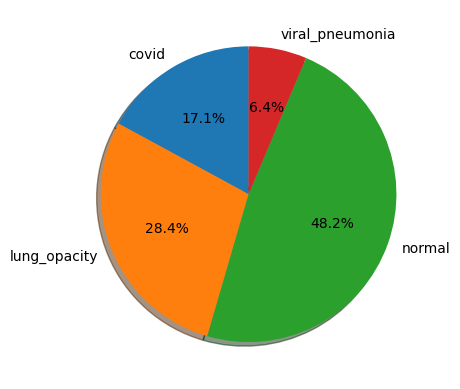

In [3]:
image_count = {}
for c in DATA_PATH.glob('*'):
    if c.is_file():
        continue
    image_count[c.name] = sum(1 for _ in (c / 'images').glob('*'))


print(image_count)
# Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(), labels=image_count.keys(), shadow=True, autopct='%1.1f%%', startangle=90)
plt.show()

I have taken correct propositions of data from each classes while staging my data to avoid overfitted results. Medical Image Datasets will always be like this, we don't have enough data on victim rather we have so many healthy ones. That is what we called is a "Skewed Dataset", obviously we developed methods to approach those problems (like K-Fold Cross Validation) that will explain that in my next notebook.

Lets view some images to know what we are dealing with here. Feel free the run the cell to view images at random from the repository.

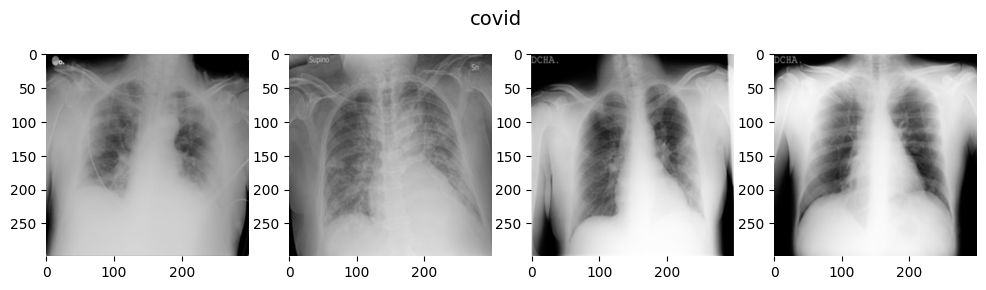

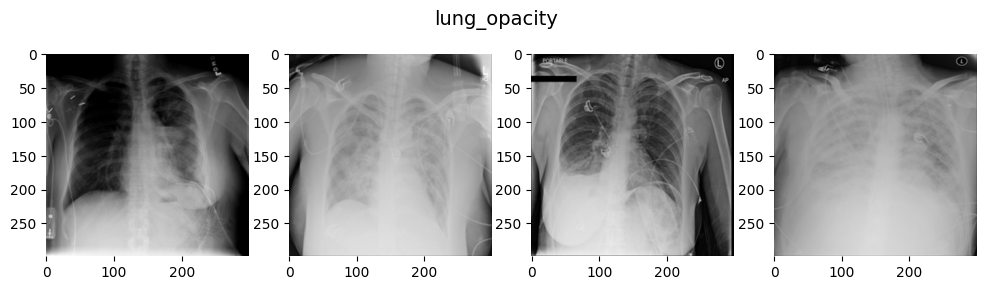

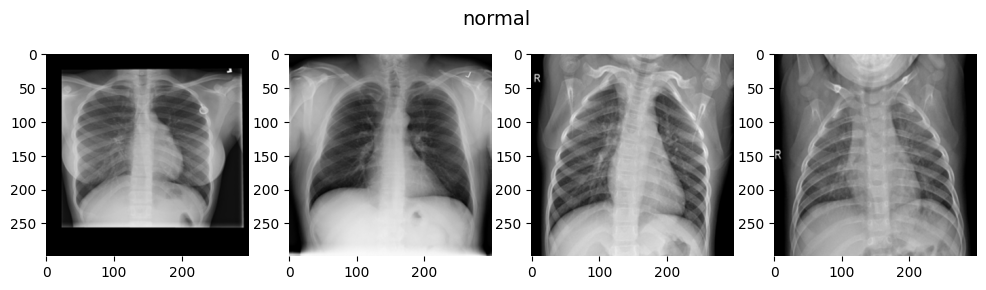

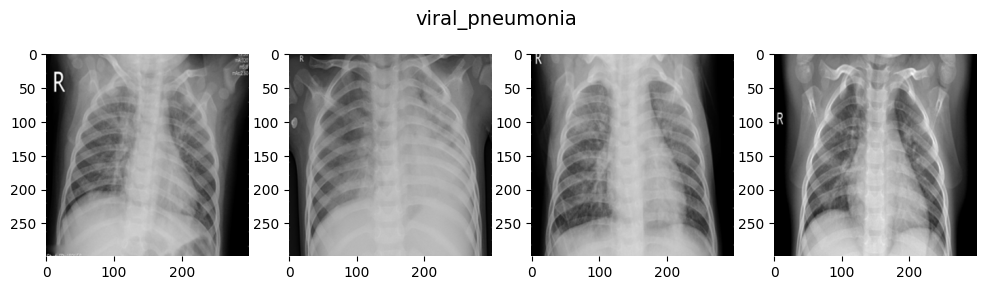

In [4]:
for cp in classes_path:
    fig = plt.figure(figsize=(12, 3))
    fig.suptitle(cp.name, size=14)

    for i, image in enumerate((cp / 'images').glob('*')):
        img = cv2.imread(str(image))
        plt.subplot(1, 4, i + 1, frameon=False)
        plt.imshow(img)
        if i == 3:
            break

In [30]:
def counterfactual_split(train_clf_pct=0.05, train_explanator_pct=0.8):
    clf_train, expl_train, expl_val = DATA_PATH / 'classifier_train.csv', DATA_PATH / 'classifier_validation.csv', DATA_PATH / 'explanator_val.csv'
    with open(clf_train, 'w') as ctr, open(expl_train, 'w') as etr, open(expl_val, 'w') as evl:
        for cp in classes_path:
            paths = list(cp.glob('images/*.png'))
            clf_num_train = int(len(paths) * train_clf_pct)
            ctr.write(
                '\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[:clf_num_train]) + '\n'
            )

            expl_num_train = int(len(paths) * train_explanator_pct)
            etr.write(
                '\n'.join(
                    cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[clf_num_train:expl_num_train]
                )
                + '\n'
            )

            expl_num_val = len(paths) - clf_num_train - expl_num_train
            evl.write(
                '\n'.join(cp.name + ',' + str(p.as_posix()) + ',' + (p.parent.parent / 'masks' / p.name).as_posix() for p in paths[-expl_num_val:]) + '\n'
            )
            print('num', cp.name, f'total={len(paths)};', 'split={}/{}/{}'.format(clf_num_train, expl_num_train, expl_num_val))
    return clf_train, expl_train, expl_val


classifier_train_csv, classifier_val_csv, exlp_val_csv = counterfactual_split(train_clf_pct=0.05, train_explanator_pct=0.8)
print('Classifier training annots:', classifier_train_csv)
print('Classifier validation annots:', classifier_val_csv)
print('Explanator validation annots:', exlp_val_csv)

num covid total=3616; split=180/2892/544
num lung_opacity total=6012; split=300/4809/903
num normal total=10192; split=509/8153/1530
num viral_pneumonia total=1345; split=67/1076/202
Classifier training annots: COVID-19_Radiography_Dataset_v2\classifier_train.csv
Classifier validation annots: COVID-19_Radiography_Dataset_v2\classifier_validation.csv
Explanator validation annots: COVID-19_Radiography_Dataset_v2\explanator_val.csv


In [31]:
imagenet_mean = 0.485, 0.456, 0.406
imagenet_std = 0.229, 0.224, 0.225
grayscale_coefs = 0.2989, 0.587, 0.114

grayscale_mean = sum(m * c for m, c in zip(imagenet_mean, grayscale_coefs))
grayscale_std = sum(m * c for m, c in zip(imagenet_std, grayscale_coefs))
# grayscale, mean_nums, std_nums
grayscale_mean, grayscale_std

(0.4589225, 0.2255861)

In [32]:
import albumentations as albu


# imagenet norm stats converted to grayscale
# mean = [grayscale_mean]
# std = [grayscale_std]
mean = [0.5]
std = [0.5]

data_transforms = {
    "train": albu.Compose(
        [
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.1),
            albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.07, p=0.5, border_mode=cv2.BORDER_CONSTANT, value=0),
            albu.Resize(256, 256, cv2.INTER_CUBIC),
            albu.Normalize(mean, std),
        ]
    ),
    "val": albu.Compose(
        [
            albu.Resize(256, 256, cv2.INTER_CUBIC),
            albu.Normalize(mean, std),
        ]
    ),
}

Text(0.5, 1.0, 'covid')

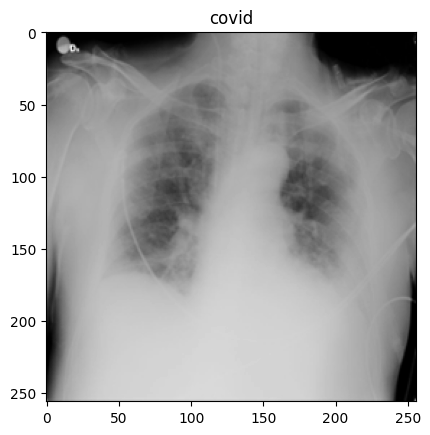

In [33]:
class LungsDataset(torch.utils.data.Dataset):
    CLASSES = 'normal', 'lung_opacity', 'viral_pneumonia', 'covid'

    def __init__(self, ann_path, transforms=None):
        self.labels, self.image_paths, self.mask_paths = self._load_anns(ann_path)
        self.labels = [self.CLASSES.index(lb) for lb in self.labels]
        self.transforms = transforms

    def _load_anns(self, ann_path):
        with open(ann_path) as fid:
            return zip(*(line.rstrip().split(',') for line in fid))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        label, img_path, mask_path = self.labels[index], self.image_paths[index], self.mask_paths[index]
        img = np.array(Image.open(img_path))
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = np.array(Image.open(mask_path))

        sample = {
            'image': img,
            'mask': mask,
        }
        if self.transforms:
            sample = self.transforms(**sample)
        sample['label'] = label
        sample['image'] = sample['image'][np.newaxis]
        sample['mask'] = (sample['mask'] / 255)[np.newaxis]
        return sample

    def get_labels(self):
        # required by https://github.com/ufoym/imbalanced-dataset-sampler/blob/master/torchsampler/imbalanced.py
        return self.labels


train_dst = LungsDataset(classifier_train_csv, data_transforms['train'])
sample = train_dst[0]
plt.imshow(sample['image'][0], cmap='gray')
plt.title(train_dst.CLASSES[sample['label']])
# val_dst = LungsDataset(DATA_PATH / 'val.csv', data_transforms['val'])

In [34]:
from torchsampler import ImbalancedDatasetSampler


def get_dataloaders(batch_size=16, use_sampler=True, shuffle_test=True):
    train_data = LungsDataset(classifier_train_csv, data_transforms['train'])
    train_sampler = ImbalancedDatasetSampler(train_data) if use_sampler else None

    test_data = LungsDataset(classifier_val_csv, data_transforms['val'])

    train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, shuffle=train_sampler is None, batch_size=batch_size, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader


train_loader, test_loader = get_dataloaders()
batch = next(iter(train_loader))

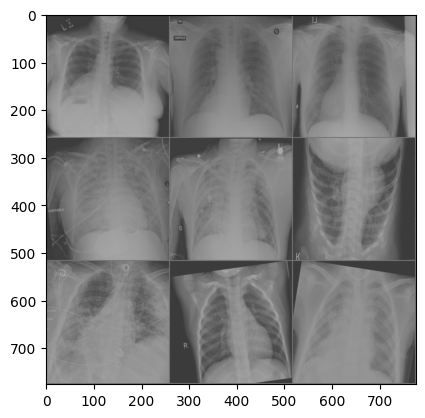

In [35]:
def imshow(inp, size=(30, 30), title=None, ax=None):
    inp = inp * grayscale_std + grayscale_mean
    inp = inp.numpy().transpose((1, 2, 0))
    if ax is None:
        plt.figure(figsize=size)
        plt.imshow(inp, ax=ax)
    ax.imshow(inp)
    if title is not None:
        plt.title(title, size=30)


batch = next(iter(train_loader))
out = torchvision.utils.make_grid(batch['image'][:9], nrow=3)
imshow(out, ax=plt.gca())

In [36]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda', index=0)

In [37]:
torch.cuda.empty_cache()

In [38]:
def get_model(pretrained=True):
    model = models.resnet18(pretrained=pretrained)  # Returns Defined Densenet model with weights trained on ImageNet
    #     in_conv = model.features.conv0
    in_conv = model.conv1
    # reset input layer to accept grayscale images
    model.conv1 = torch.nn.Conv2d(
        1, in_conv.out_channels, in_conv.kernel_size, in_conv.stride, in_conv.padding, in_conv.dilation, in_conv.groups, in_conv.bias, in_conv.padding_mode
    )
    model.conv1.weight.data.copy_(in_conv.weight.mean(dim=1, keepdims=True))
    if in_conv.bias is not None:
        model.conv1.bias.data.copy_(in_conv.bias)

    # reset the classification layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(LungsDataset.CLASSES))
    model = model.to(device)
    return model

In [39]:
from sklearn.metrics import classification_report


def train_epoch(loader, model, criterion, optimizer, report=False):
    model.train()
    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='train', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        #         preds = (outputs > 0).byte()
        #         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()
        #         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())
    if report:
        report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
        print(report)
    return current_loss / len(loader)


@torch.no_grad()
def validation_epoch(loader, model, criterion):
    model.eval()

    current_loss = 0.0
    pred_list, true_list = [], []
    for batch in tqdm.tqdm(loader, desc='val', leave=False):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
        #         preds = (outputs > 0).byte()
        #         loss = criterion(outputs, labels.float().unsqueeze(1))
        preds = outputs.argmax(1)
        loss = criterion(outputs, labels)
        # We want variables to hold the loss statistics
        current_loss += loss.item()
        #         pred_list.extend(preds.squeeze(1).cpu().numpy())
        pred_list.extend(preds.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

    report = classification_report(true_list, pred_list, target_names=loader.dataset.CLASSES)
    print('Validation report:')
    print(report)
    return current_loss / len(loader)


def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        train_epoch_loss = train_epoch(dataloaders['train'], model, criterion, optimizer)
        print('Epoch {}. Train Loss: {:.4f}'.format(epoch + 1, train_epoch_loss))

        val_epoch_loss = validation_epoch(dataloaders['val'], model, criterion)
        print('Epoch {}. Validation Loss: {:.4f}'.format(epoch + 1, val_epoch_loss))

        scheduler.step()
        print('LR:', optimizer.param_groups[0]['lr'])

        if val_epoch_loss < best_loss:
            print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, val_epoch_loss))
            best_loss = val_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    model.load_state_dict(best_model_wts)
    return model

In [40]:
from collections import Counter

train_labels = np.array(train_loader.dataset.labels)

counts = Counter(train_labels)
print(counts)
class_weights = torch.zeros(len(counts)).to(device)
for c, v in counts.items():
    class_weights[c] = 1.0 - v / len(train_labels)
class_weights
# num_covid = sum(train_labels)
# num_normal = len(train_labels) - num_covid
# class_weights = torch.tensor((1 - num_normal / len(train_labels), 1 - num_covid / len(train_labels))).to(device)
# class_weights

Counter({0: 509, 1: 300, 3: 180, 2: 67})


tensor([0.5180, 0.7159, 0.9366, 0.8295], device='cuda:0')

In [41]:
np.random.seed(777)
torch.manual_seed(777)

dataloaders = {'train': train_loader, 'val': test_loader}

model = get_model(pretrained=True)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 5], gamma=0.5)
print('Number of trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

base_model = train_model(model, criterion, optimizer, scheduler, num_epochs=8)

C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\Desktop\UT\ml-special-course\kaggle2\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of trainable parameters: 11172292
Epoch 1/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1. Train Loss: 0.4735


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.88      0.70      0.78      7644
   lung_opacity       0.84      0.78      0.81      4509
viral_pneumonia       0.94      0.90      0.92      1009
          covid       0.51      0.88      0.65      2712

       accuracy                           0.77     15874
      macro avg       0.79      0.81      0.79     15874
   weighted avg       0.81      0.77      0.77     15874

Epoch 1. Validation Loss: 0.5467
LR: 0.0001
Val loss Decreased from inf to 0.5467 
Saving Weights... 

Epoch 2/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2. Train Loss: 0.2030


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.89      0.82      0.86      7644
   lung_opacity       0.71      0.92      0.80      4509
viral_pneumonia       0.89      0.95      0.92      1009
          covid       0.91      0.66      0.76      2712

       accuracy                           0.83     15874
      macro avg       0.85      0.84      0.83     15874
   weighted avg       0.84      0.83      0.83     15874

Epoch 2. Validation Loss: 0.4639
LR: 0.0001
Val loss Decreased from 0.5467 to 0.4639 
Saving Weights... 

Epoch 3/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3. Train Loss: 0.1365


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.74      0.82      7644
   lung_opacity       0.66      0.94      0.77      4509
viral_pneumonia       0.98      0.88      0.93      1009
          covid       0.89      0.75      0.81      2712

       accuracy                           0.81     15874
      macro avg       0.86      0.83      0.83     15874
   weighted avg       0.84      0.81      0.81     15874

Epoch 3. Validation Loss: 0.5175
LR: 5e-05

Epoch 4/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4. Train Loss: 0.1157


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.89      0.89      0.89      7644
   lung_opacity       0.86      0.84      0.85      4509
viral_pneumonia       0.97      0.90      0.94      1009
          covid       0.82      0.85      0.83      2712

       accuracy                           0.87     15874
      macro avg       0.88      0.87      0.88     15874
   weighted avg       0.87      0.87      0.87     15874

Epoch 4. Validation Loss: 0.3930
LR: 5e-05
Val loss Decreased from 0.4639 to 0.3930 
Saving Weights... 

Epoch 5/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 5. Train Loss: 0.1074


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.93      0.77      0.84      7644
   lung_opacity       0.74      0.91      0.81      4509
viral_pneumonia       0.98      0.87      0.92      1009
          covid       0.75      0.88      0.81      2712

       accuracy                           0.83     15874
      macro avg       0.85      0.86      0.85     15874
   weighted avg       0.85      0.83      0.83     15874

Epoch 5. Validation Loss: 0.4529
LR: 2.5e-05

Epoch 6/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 6. Train Loss: 0.0851


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.90      0.90      0.90      7644
   lung_opacity       0.84      0.87      0.85      4509
viral_pneumonia       0.98      0.88      0.93      1009
          covid       0.88      0.86      0.87      2712

       accuracy                           0.88     15874
      macro avg       0.90      0.88      0.89     15874
   weighted avg       0.88      0.88      0.88     15874

Epoch 6. Validation Loss: 0.3570
LR: 2.5e-05
Val loss Decreased from 0.3930 to 0.3570 
Saving Weights... 

Epoch 7/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 7. Train Loss: 0.0829


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.91      0.86      0.88      7644
   lung_opacity       0.77      0.92      0.84      4509
viral_pneumonia       0.97      0.89      0.93      1009
          covid       0.94      0.80      0.86      2712

       accuracy                           0.87     15874
      macro avg       0.90      0.87      0.88     15874
   weighted avg       0.88      0.87      0.87     15874

Epoch 7. Validation Loss: 0.4056
LR: 2.5e-05

Epoch 8/8
----------


train:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 8. Train Loss: 0.0671


val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.92      0.81      0.86      7644
   lung_opacity       0.72      0.93      0.81      4509
viral_pneumonia       0.98      0.89      0.93      1009
          covid       0.93      0.83      0.88      2712

       accuracy                           0.85     15874
      macro avg       0.88      0.86      0.87     15874
   weighted avg       0.87      0.85      0.85     15874

Epoch 8. Validation Loss: 0.4250
LR: 2.5e-05

Training complete in 9m 23s
Best val loss: 0.3570


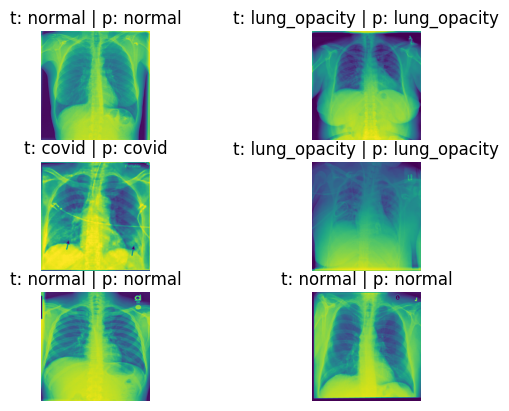

In [42]:
@torch.no_grad()
def visualize_model(model, num_images=6):
    model.eval()
    images_handled = 0
    ax = plt.figure()

    classes = LungsDataset.CLASSES
    for i, batch in enumerate(dataloaders['val']):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)

        outputs = model(inputs)
        #         preds = (outputs > 0).byte().squeeze(1)
        preds = outputs.argmax(1)

        for j in range(inputs.size()[0]):
            images_handled += 1
            ax = plt.subplot(num_images // 2, 2, images_handled)
            ax.axis('off')
            ax.set_title('t: {} | p: {}'.format(classes[labels[j].item()], classes[preds[j]]))
            imshow(inputs.cpu()[j], (5, 5), ax=ax)

            if images_handled == num_images:
                return


visualize_model(model)
plt.show()

In [43]:
torch.save(model.state_dict(), 'resnet18_multiclass_pretrain.pth')
validation_epoch(test_loader, model, criterion)

val:   0%|          | 0/993 [00:00<?, ?it/s]

Validation report:
                 precision    recall  f1-score   support

         normal       0.90      0.90      0.90      7644
   lung_opacity       0.84      0.87      0.85      4509
viral_pneumonia       0.98      0.88      0.93      1009
          covid       0.88      0.86      0.87      2712

       accuracy                           0.88     15874
      macro avg       0.90      0.88      0.89     15874
   weighted avg       0.88      0.88      0.88     15874



0.3569450403619014

In [44]:
@torch.no_grad()
def predict_probs(loader, model):
    model.eval()
    probs = []
    classes = []
    for i, batch in tqdm.tqdm(enumerate(loader), total=len(loader)):
        inputs, labels = batch['image'].to(device), batch['label'].to(device)
        outputs = model(inputs)
        #         preds = outputs.sigmoid().squeeze(1)
        preds = outputs.softmax(1)
        probs.extend(preds.cpu().numpy())
        classes.extend(labels.cpu().numpy())
    return probs, classes


_, test_loader = get_dataloaders(use_sampler=False, batch_size=32, shuffle_test=False)
probs, classes = predict_probs(test_loader, model)

  0%|          | 0/497 [00:00<?, ?it/s]

(array([7644., 4509., 1009., 2712.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

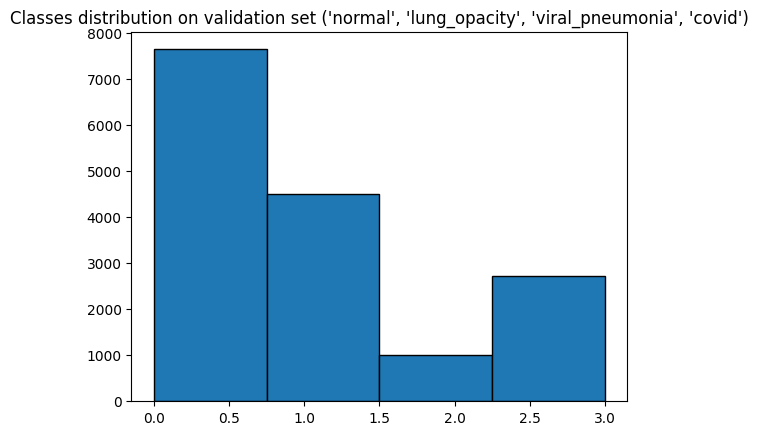

In [45]:
plt.title('Classes distribution on validation set ' + str(LungsDataset.CLASSES))
plt.hist(classes, bins=len(LungsDataset.CLASSES), edgecolor='black')

[8267 7607]
[11283  4591]
[14981   893]
[13296  2578]


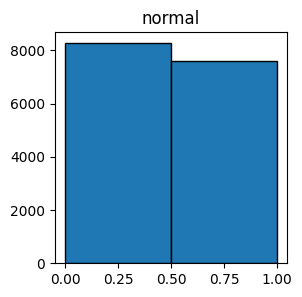

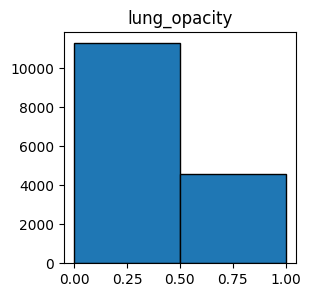

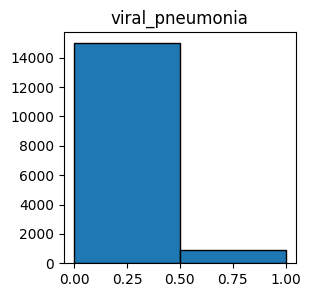

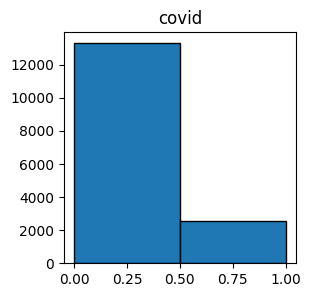

In [48]:
for explain_class in range(len(LungsDataset.CLASSES)):
    pbs = [item[explain_class] for item in probs]
    hist, bins = np.histogram(pbs, range=(0, 1), bins=2)
    plt.figure(figsize=(3, 3))
    plt.hist(pbs, bins=bins, edgecolor='black')
    plt.title(LungsDataset.CLASSES[explain_class])
    print(hist)

In [49]:
explain_class = LungsDataset.CLASSES.index('normal')
pbs = [item[explain_class] for item in probs]
num_bins = 2
bin_step = 1 / num_bins
bins = np.arange(0, 1, bin_step)
bin_ids = np.digitize(pbs, bins=bins) - 1
for i, (x, y) in enumerate(zip(pbs, bin_ids)):
    if x < 1e-3:
        continue
    print(x, y)
    if i > 50:
        break

0.11279989 0
0.002339286 0
0.0022558398 0
0.001927016 0
0.012777782 0
0.004209401 0
0.7662343 1
0.003051407 0
0.9454504 1
0.023407588 0
0.0014321507 0
0.96974427 1
0.0014528497 0
0.4638182 0
0.0017060604 0
0.0014607579 0
0.75152117 1
0.0035384702 0
0.013598177 0
